### Project 31 - Porto Seguro’s Safe Driver Prediction - Predict if a driver will file an insurance claim next year.
## Phase 4: Advanced Modeling and Feature Engineering

**In this phase, we will use the below algorithms for our modeling:**

1. Random Forests
2. Gradient Boosted Trees
3. Stacking Ensemble
4. Multi Layer Perceptron

**For model evaluation/ error analysis, we will evaluate/analyse the models using:**

1. AUROC
2. Log Loss
3. Normalized Gini Coefficient

Import the libraries that we'll need

In [1]:
# Numpy and Pandas
import numpy as np
import pandas as pd
pd.set_option('display.max_columns', 100)

# Matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

# Seaborn for easier visualization
import seaborn as sns
sns.set_style('darkgrid')

# Supress Future warning
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=UserWarning)
warnings.simplefilter(action='ignore', category=DeprecationWarning)

# import scikit learn
import sklearn
sklearn.set_config(print_changed_only=False)

# For train-test split
from sklearn.model_selection import train_test_split

# Feature Scaling using StandardScaler
from sklearn.preprocessing import StandardScaler

In [50]:
# Import Naive Bayes
from sklearn.naive_bayes import GaussianNB

# Import Logistic Regression
from sklearn.linear_model import LogisticRegression

# Import DecisionTreeClassifier
from sklearn.tree import DecisionTreeClassifier

# Function for creating model pipelines
from sklearn.pipeline import make_pipeline

# Cross_validation
from sklearn.model_selection import RandomizedSearchCV, RepeatedStratifiedKFold, cross_val_score

# Import Ensembles
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, StackingClassifier

# Import MLP
from sklearn.neural_network import MLPClassifier

In [3]:
# Import confusion_matrix
from sklearn.metrics import confusion_matrix

# Classification metrics
from sklearn.metrics import roc_curve, roc_auc_score, log_loss

# Import pickle
import pickle

## Helper functions

**1. Function to calculate Gini coefficient and Normalized Gini Coefficient**

In [4]:
# Function to calculate Gini coefficient and Normalized Gini Coefficient
def gini(actual, pred):
    if (len(actual) == len(pred)):
        all = np.asarray(np.c_[actual, pred, np.arange(len(actual))], dtype=np.float)
        all = all[np.lexsort((all[:, 2], -1 * all[:, 1]))]
        totalLosses = all[:, 0].sum()
        giniSum = all[:, 0].cumsum().sum() / totalLosses

        giniSum -= (len(actual) + 1) / 2.
        return giniSum / len(actual)
    return 0

# Function to calculate Normalized Gini Coefficient
def gini_normalized(actual, pred):
    return gini(actual, pred) / gini(actual, actual)

**2. Function to fit a RandomizedSearchCV model of specified algorithm and display its cross-validated score**

In [5]:
# Function to fit a RandomizedSearchCV model of specified algorithm and display its cross-validated score
def fit_model_and_display_score(name, X_train, y_train, cv_val):
    # Create cross-validation object from pipeline and hyperparameters
    model = RandomizedSearchCV(estimator=pipelines[name],
                    param_distributions=hyperparameters[name],
                    cv=cv_val,
                    n_jobs=-1,
                    random_state=123,
                    verbose=1)
    
    # Fit model on X_train, y_train
    model.fit(X_train, y_train)
    
    # Print '{name} has been fitted'
    print(name, 'has been fitted')
      
    # Best score and params
    print("Best CV score for "+ name + ": ") 
    print( np.round(model.best_score_, 3) )
    print("Best parameters for " + name + ": ") 
    print( model.best_params_ )
    
    # return the model
    return model

**3. Function to display Confusion Matrix, TPR and FPR**

In [6]:
# Function to display Confusion Matrix, TPR and FPR
def display_model_cm_fpt_tpr(y_test, pred):
    # Confusion Matrix
    print("Confusion Matrix:")
    cm = confusion_matrix (y_test, pred)
    print( cm )
    print()
    # True Positives (TP)
    tp = cm[1][1]

    # False Positives (FP)
    fp = cm[0][1]

    # True Negatives (TN)
    tn = cm[0][0]

    # False Negatives (FN)
    fn = cm[1][0]
    
    #TPR
    true_positive_rate = tp/(tp+fn)
    print( 'TPR:', np.round(true_positive_rate, 3) )
    
    #FPR
    false_positive_rate = fp/(tn+fp)
    print( 'FPR:', np.round(false_positive_rate, 3) )

**4. Function to determine best threshold for classification models**

NOTE: The below code for g-means and threshold is partially taken from *https://machinelearningmastery.com/threshold-moving-for-imbalanced-classification/*

In [7]:
# Function to determine best threshold for classification models
def find_best_classification_threshold(y_test, pred_prob):
    # calculate roc curves
    fpr, tpr, thresholds = roc_curve(y_test, pred_prob)

    # calculate the geometric mean for each threshold
    gmeans = np.sqrt(tpr * (1-fpr))
    
    # locate the index of the largest g-mean
    ix = np.argmax(gmeans)
    print('Best Threshold=%.3f, G-Mean=%.3f' % (thresholds[ix], gmeans[ix]))
    
    #return best threshold
    return thresholds[ix]

**5. Function to save a fitted model to disk**

In [8]:
# Function to save a fitted model to disk
def save_model_to_disk(model, filename):
    filename = filename
    pickle.dump(model, open(filename, 'wb'))
    print("Model saved to disk as", filename)

## Load the dataset and perform train-test split

Load our analytical base (table from previous phase)

In [9]:
abt = pd.read_csv('analytical_base_table.csv')

In [10]:
print(abt.shape)

abt.head()

(595212, 39)


,ps_calc_02,ps_ind_12_bin,ps_ind_07_bin,ps_ind_15,ps_car_08_cat,ps_car_02_cat,ps_car_13,ps_car_07_cat,ps_car_04_cat,ps_car_14,ps_ind_02_cat,ps_ind_17_bin,ps_car_11,ps_ind_18_bin,ps_car_12,ps_ind_04_cat,ps_reg_03,ps_reg_01,ps_car_15,ps_calc_01,ps_car_09_cat,ps_ind_14,ps_ind_16_bin,ps_ind_05_cat,ps_ind_11_bin,ps_ind_01,ps_reg_02,ps_ind_08_bin,ps_car_10_cat,ps_car_03_cat,ps_car_05_cat,ps_car_01_cat,ps_car_06_cat,ps_calc_03,ps_ind_10_bin,ps_ind_06_bin,ps_ind_03,ps_ind_09_bin,target
0,0.5,0,1,11,0,1,0.883679,1,0,0.370810,2,1,2,0,0.400000,1,0.718070,0.7,3.605551,0.6,0,0,0,0,0,2,0.2,0,1,-1,1,10,4,0.2,0,0,5,0,0
1,0.1,0,0,3,1,1,0.618817,1,0,0.388716,1,0,3,1,0.316228,0,0.766078,0.8,2.449490,0.3,2,0,0,0,0,1,0.4,1,1,-1,-1,11,11,0.3,0,0,7,0,0
2,0.7,0,0,12,1,1,0.641586,1,0,0.347275,4,0,1,0,0.316228,1,-1.000000,0.0,3.316625,0.5,2,0,1,0,0,5,0.0,1,1,-1,-1,7,14,0.1,0,0,9,0,0
3,0.9,0,0,8,1,1,0.542949,1,0,0.294958,1,0,1,0,0.374166,0,0.580948,0.9,2.000000,0.6,3,0,1,0,0,0,0.2,0,1,0,1,7,11,0.1,0,1,2,0,0
4,0.6,0,0,9,1,1,0.565832,1,0,0.365103,2,0,3,0,0.316070,1,0.840759,0.7,2.000000,0.4,2,0,1,0,0,0,0.6,0,1,-1,-1,11,14,0.0,0,1,0,0,0


Separate the dataframe into separate objects for the imput features(X) and target variable(y)

In [11]:
X = abt.drop('target', axis=1)
y = abt.target

In [12]:
print(X.shape)
print(y.shape)

(595212, 38)
(595212,)


Split X and y into training an test sets

In [13]:
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                   test_size=0.2,
                                                   stratify=abt.target,
                                                   random_state=1234)

print(len(X_train), len(X_test), len(y_train), len(y_test))

476169 119043 476169 119043


In [14]:
y_train.value_counts()

0    458814
1     17355
Name: target, dtype: int64

In [15]:
y_test.value_counts()

0    114704
1      4339
Name: target, dtype: int64

## Build the model Pipeline

NOTE: We will add more algorithms to the pipeline as we need

In [16]:
#Crete the Pipeline dictionary
pipelines = {
    'rf': make_pipeline(StandardScaler(), RandomForestClassifier(random_state=123)),
    'gb': make_pipeline(StandardScaler(), GradientBoostingClassifier(random_state=123))
}

In [17]:
# Create hyperparameters dictionary
hyperparameters = {}

Create empty dictionary called fitted_models, to include models that have been tuned using cross-validation

In [18]:
fitted_models = {}

### 1. Random Forests Classifier

Declare the parameter grid for **rf (Random Forests Classifier)**

In [19]:
# Random Forest hyperparameters
rf_hyperparameters = {
    'randomforestclassifier__n_estimators': [100, 200],
    'randomforestclassifier__max_features': ['auto', 'sqrt', 0.33],
    'randomforestclassifier__min_samples_leaf': [1, 3, 5, 10]
}

Create or Update the hyperparameters dictionary. We will add to this dictionary, as we apply more algorithms

In [20]:
# Create or Update hyperparameters dictionary
hyperparameters['rf'] = rf_hyperparameters

**Fit the Random Forests Classifier model, and save it into fitted_models dictionary**

In [21]:
rf_model = fit_model_and_display_score(name='rf', X_train=X_train, y_train=y_train, cv_val=10)

Fitting 10 folds for each of 10 candidates, totalling 100 fits
rf has been fitted
Best CV score for rf: 
0.964
Best parameters for rf: 
{'randomforestclassifier__n_estimators': 100, 'randomforestclassifier__min_samples_leaf': 3, 'randomforestclassifier__max_features': 0.33}


We find that **Random Forest Classifier with n_estimators = 100, min_samples_leaf = 3 and max_features = 0.33** is our RandomForestClassifier's best estimator with **cross-validated score of 0.964**

In [22]:
# Store model in fitted_models[name] 
fitted_models['rf'] = rf_model

In [23]:
# Save the Random Forest Classifier model to disk
save_model_to_disk(rf_model, 'rf_model.sav')

Model saved to disk as rf_model.sav


Get the **predicted classes** from our Random Forest Classifier model

In [24]:
# Predict classes using our fitted Random Forest Classifier model
rf_pred = fitted_models['rf'].predict(X_test)

Check the **Confusion Matrix, TPR and FPR**

In [25]:
display_model_cm_fpt_tpr(y_test, rf_pred)

Confusion Matrix:
[[114702      2]
 [  4339      0]]

TPR: 0.0
FPR: 0.0


**TPR and FPR values are 'zero'**, i.e., **the fitted Random Forest Classifier predicts only negative class**  with the default threshold=0.5.

Lets find the best threshold for Random Forest Classifier model (using G-Mean).

In [26]:
# Predict PROBABILITIES using fitted Random Forest Classifier
rf_pred_prob = fitted_models['rf'].predict_proba(X_test)

# Get JUST the PREDICTION PROBABILITY for positive class
rf_pred_prob = [ p[1] for p in rf_pred_prob ]

In [27]:
# Best threshold for Random Forest Classifier model
rf_threshold = np.round( find_best_classification_threshold(y_test, rf_pred_prob), 3 )

Best Threshold=0.039, G-Mean=0.572


Get the updated predictions with the **best threshold=0.039**

In [28]:
rf_pred = (fitted_models['rf'].predict_proba(X_test)[:,1] >= 0.039).astype(bool)

# Display confusion matrix for y_test and pred
display_model_cm_fpt_tpr(y_test, rf_pred)

Confusion Matrix:
[[64883 49821]
 [ 1837  2502]]

TPR: 0.577
FPR: 0.434


Lets check the **AUROC, Log Loss and Gini Coefficient**  of the Random Forest Classifier model

In [29]:
# Calculate AUROC
print("For Random Forest Classifier model:")
print( "AUROC: ",np.round(roc_auc_score(y_test, rf_pred_prob),3) )

# Calculate Log-Loss
log_loss_rf = np.round(log_loss(y_test, rf_pred_prob), 3)
print("Log Loss: ", log_loss_rf)

# Calculate Gini Coefficient
print("Normalized Gini Coefficient: ", np.round(gini_normalized(y_test, rf_pred),3) )

For Random Forest Classifier model:
AUROC:  0.599
Log Loss:  0.162
Normalized Gini Coefficient:  0.145


**Summary of the Random Forest Classifier model:**
1. We get cross-validated score of 0.964
2. True Positive rate = 0.577, False Positive Rate = 0.434
3. We get AUROC of 0.599 (Still our Logistic Regression models are better than the Random Forest model)
4. Log-Loss of 0.162 (Still our Logistic Regression models are better than the Random Forest model)
5. Normalized Gini Coefficient = 0.145 (Still our Logistic Regression models are better than the Random Forest model)

So, we see that our Logistic Regression models perform better as compared to the Random Forest Classifier model

### 2. Gradient Boosting Trees Classifier

Declare the parameter grid for **gb (Gradient Boosting Tree Classifier)**

In [30]:
# Gradient Boosting Tree hyperparameters
gb_hyperparameters = {
    'gradientboostingclassifier__n_estimators': [100, 200],
    'gradientboostingclassifier__learning_rate': [0.05, 0.1, 0.2],
    'gradientboostingclassifier__max_depth': [1, 3, 5]
}

Create or Update the hyperparameters dictionary. We will add to this dictionary, as we apply more algorithms

In [31]:
# Create or Update hyperparameters dictionary
hyperparameters['gb'] = gb_hyperparameters

**Fit the Gradient Boosting Trees Classifier model, and save it into fitted_models dictionary**

In [32]:
gb_model = fit_model_and_display_score(name='gb', X_train=X_train, y_train=y_train, cv_val=10)

Fitting 10 folds for each of 10 candidates, totalling 100 fits
gb has been fitted
Best CV score for gb: 
0.964
Best parameters for gb: 
{'gradientboostingclassifier__n_estimators': 200, 'gradientboostingclassifier__max_depth': 1, 'gradientboostingclassifier__learning_rate': 0.1}


We find that **Gradient Boosting Decision Trees Classifier with n_estimators = 200, max_depth = 1 and learning_rate = 0.1** is our GBDT's best estimator with **cross-validated score of 0.964**

In [33]:
# Store model in fitted_models[name] 
fitted_models['gb'] = gb_model

In [34]:
# Save the Gradient Boosting Trees Classifier model to disk
save_model_to_disk(gb_model, 'gb_model.sav')

Model saved to disk as gb_model.sav


Get the **predicted classes** from our Gradient Boosting Decision Trees Classifier model

In [35]:
# Predict classes using our fitted Gradient Boosting Decision Trees Classifier model
gb_pred = fitted_models['gb'].predict(X_test)

Check the **Confusion Matrix, TPR and FPR**

In [36]:
display_model_cm_fpt_tpr(y_test, gb_pred)

Confusion Matrix:
[[114704      0]
 [  4339      0]]

TPR: 0.0
FPR: 0.0


**TPR and FPR values are 'zero'**, i.e., **the fitted Gradient Boosting Decision Trees Classifier predicts only negative class**  with the default threshold=0.5.

Lets find the best threshold for Gradient Boosting Decision Trees Classifier model (using G-Mean).

In [37]:
# Predict PROBABILITIES using fitted Gradient Boosting Decision Trees Classifier
gb_pred_prob = fitted_models['gb'].predict_proba(X_test)

# Get JUST the PREDICTION PROBABILITY for positive class
gb_pred_prob = [ p[1] for p in gb_pred_prob ]

In [38]:
# Best threshold for Gradient Boosting Decision Trees Classifier model
gb_threshold = np.round( find_best_classification_threshold(y_test, gb_pred_prob), 3 )

Best Threshold=0.035, G-Mean=0.587


Get the updated predictions with the **best threshold=0.035**

In [39]:
gb_pred = (fitted_models['gb'].predict_proba(X_test)[:,1] >= 0.035).astype(bool)

# Display confusion matrix for y_test and pred
display_model_cm_fpt_tpr(y_test, gb_pred)

Confusion Matrix:
[[65604 49100]
 [ 1737  2602]]

TPR: 0.6
FPR: 0.428


Lets check the **AUROC, Log Loss and Gini Coefficient**  of the Gradient Boosting Decision Trees Classifier model

In [40]:
# Calculate AUROC
print("For Gradient Boosting Decision Trees Classifier model:")
print( "AUROC: ",np.round(roc_auc_score(y_test, gb_pred_prob),3) )

# Calculate Log-Loss
log_loss_gb = np.round(log_loss(y_test, gb_pred_prob), 3)
print("Log Loss: ", log_loss_gb)

# Calculate Gini Coefficient
print("Normalized Gini Coefficient: ", np.round(gini_normalized(y_test, gb_pred),3) )

For Gradient Boosting Decision Trees Classifier model:
AUROC:  0.626
Log Loss:  0.153
Normalized Gini Coefficient:  0.173


**Summary of the Gradient Boosting Decision Trees Classifier model:**
1. We get cross-validated score of 0.964
2. True Positive rate = 0.6, False Positive Rate = 0.428
3. We get AUROC of 0.626 (Sightly better than the Logistic Regression models)
4. Log-Loss of 0.153 (Same as the Logistic Regression models)
5. Normalized Gini Coefficient = 0.173 (Same as the Logistic Regression models)

So, we see that our Gradient Boosting Decision Trees Classifier model performance is slightly better than the Logistic Regression models

### 3. Stacking Classifier

Define the **base learners** for the Stacking Ensemble Classifier

In [41]:
# Create Base Learners
base_learners = [
    ('nb_clf', make_pipeline(StandardScaler(), 
                             GaussianNB(var_smoothing=1.0)) ),
     
    ('dt_clf', make_pipeline(StandardScaler(), 
                             DecisionTreeClassifier(splitter='best', min_samples_leaf= 10, max_features = 10, 
                                                    max_depth= 6, criterion= 'gini', random_state=123)) ),
     
    ('rf_clf', make_pipeline(StandardScaler(), 
                             RandomForestClassifier(n_estimators = 100, min_samples_leaf = 3, 
                                                    max_features = 0.33,random_state=123)) ),
     
    ('gb_clf', make_pipeline(StandardScaler(), 
                             GradientBoostingClassifier(n_estimators = 200, max_depth = 1 ,
                                                         learning_rate = 0.1, random_state=123)) )
     
]

Define the **meta learner model (L1-Logistic Regression)** and the **Stacking Ensemble**

In [42]:
# Initialize Stacking Classifier with the Meta Learner and Cross-validation
stack_clf = StackingClassifier(estimators=base_learners, 
                               final_estimator=make_pipeline(StandardScaler(), 
                                                             LogisticRegression(penalty='l1', solver = 'liblinear',
                                                                                C=5, random_state=123)), 
                               cv=10,
                               stack_method='predict',
                               verbose=2,
                               n_jobs=-1)

Fit and save the Stacking Ensemble Classifier model

In [43]:
# Fit the Stacking Ensemble Classifier
stack_model = stack_clf.fit(X_train, y_train)

In [52]:
# Store model in fitted_models[name] 
fitted_models['stk'] = stack_model

In [53]:
# Save the Stacking Classifier model to disk
save_model_to_disk(stack_model, 'stack_model.sav')

Model saved to disk as stack_model.sav


Get the **predicted classes** from our Stacking Ensemble Classifier model

In [54]:
# Predict classes using our fitted Stacking Ensemble Classifier model
stack_pred = fitted_models['stk'].predict(X_test)

Check the **Confusion Matrix, TPR and FPR**

In [55]:
display_model_cm_fpt_tpr(y_test, stack_pred)

Confusion Matrix:
[[114703      1]
 [  4338      1]]

TPR: 0.0
FPR: 0.0


**TPR and FPR values are 'zero'**, i.e., **the fitted Stacking Ensemble Classifier predicts only negative class**  with the default threshold=0.5.

Lets find the best threshold for Stacking Ensemble Classifier model (using G-Mean).

In [56]:
# Predict PROBABILITIES using fitted Stacking Ensemble Classifier
stack_pred_prob = fitted_models['stk'].predict_proba(X_test)

# Get JUST the PREDICTION PROBABILITY for positive class
stack_pred_prob = [ p[1] for p in stack_pred_prob ]

In [57]:
# Best threshold for Stacking Ensemble Classifier model
stack_threshold = np.round( find_best_classification_threshold(y_test, stack_pred_prob), 3 )

Best Threshold=0.064, G-Mean=0.187


Get the updated predictions with the **best threshold=0.064**

In [58]:
stack_pred = (fitted_models['stk'].predict_proba(X_test)[:,1] >= 0.064).astype(bool)

# Display confusion matrix for y_test and pred
display_model_cm_fpt_tpr(y_test, stack_pred)

Confusion Matrix:
[[114699      5]
 [  4338      1]]

TPR: 0.0
FPR: 0.0


Lets check the **AUROC, Log Loss and Gini Coefficient**  of the Gradient Boosting Decision Trees Classifier model

In [59]:
# Calculate AUROC
print("For Stacking Ensemble Classifier model:")
print( "AUROC: ",np.round(roc_auc_score(y_test, stack_pred_prob),3) )

# Calculate Log-Loss
log_loss_stack = np.round(log_loss(y_test, stack_pred_prob), 3)
print("Log Loss: ", log_loss_stack)

# Calculate Gini Coefficient
print("Normalized Gini Coefficient: ", np.round(gini_normalized(y_test, stack_pred),3) )

For Stacking Ensemble Classifier model:
AUROC:  0.508
Log Loss:  0.156
Normalized Gini Coefficient:  0.004


**Summary of the Stacking Ensemble Classifier model:**
1. True Positive rate = 0.0, False Positive Rate = 0.0
2. We get AUROC of 0.508 
3. Log-Loss of 0.156
4. Normalized Gini Coefficient = 0.004 

So, we have better performing models than the Stacking Ensemble Classifier.

### 4. Multi Layer Perceptron Classifier

Load the entire dataset

In [62]:
# Read the dataset
df = pd.read_csv('Dataset/train.csv')
df.head()

,id,target,ps_ind_01,ps_ind_02_cat,ps_ind_03,ps_ind_04_cat,ps_ind_05_cat,ps_ind_06_bin,ps_ind_07_bin,ps_ind_08_bin,ps_ind_09_bin,ps_ind_10_bin,ps_ind_11_bin,ps_ind_12_bin,ps_ind_13_bin,ps_ind_14,ps_ind_15,ps_ind_16_bin,ps_ind_17_bin,ps_ind_18_bin,ps_reg_01,ps_reg_02,ps_reg_03,ps_car_01_cat,ps_car_02_cat,ps_car_03_cat,ps_car_04_cat,ps_car_05_cat,ps_car_06_cat,ps_car_07_cat,ps_car_08_cat,ps_car_09_cat,ps_car_10_cat,ps_car_11_cat,ps_car_11,ps_car_12,ps_car_13,ps_car_14,ps_car_15,ps_calc_01,ps_calc_02,ps_calc_03,ps_calc_04,ps_calc_05,ps_calc_06,ps_calc_07,ps_calc_08,ps_calc_09,ps_calc_10,ps_calc_11,ps_calc_12,ps_calc_13,ps_calc_14,ps_calc_15_bin,ps_calc_16_bin,ps_calc_17_bin,ps_calc_18_bin,ps_calc_19_bin,ps_calc_20_bin
0,7,0,2,2,5,1,0,0,1,0,0,0,0,0,0,0,11,0,1,0,0.7,0.2,0.718070,10,1,-1,0,1,4,1,0,0,1,12,2,0.400000,0.883679,0.370810,3.605551,0.6,0.5,0.2,3,1,10,1,10,1,5,9,1,5,8,0,1,1,0,0,1
1,9,0,1,1,7,0,0,0,0,1,0,0,0,0,0,0,3,0,0,1,0.8,0.4,0.766078,11,1,-1,0,-1,11,1,1,2,1,19,3,0.316228,0.618817,0.388716,2.449490,0.3,0.1,0.3,2,1,9,5,8,1,7,3,1,1,9,0,1,1,0,1,0
2,13,0,5,4,9,1,0,0,0,1,0,0,0,0,0,0,12,1,0,0,0.0,0.0,-1.000000,7,1,-1,0,-1,14,1,1,2,1,60,1,0.316228,0.641586,0.347275,3.316625,0.5,0.7,0.1,2,2,9,1,8,2,7,4,2,7,7,0,1,1,0,1,0
3,16,0,0,1,2,0,0,1,0,0,0,0,0,0,0,0,8,1,0,0,0.9,0.2,0.580948,7,1,0,0,1,11,1,1,3,1,104,1,0.374166,0.542949,0.294958,2.000000,0.6,0.9,0.1,2,4,7,1,8,4,2,2,2,4,9,0,0,0,0,0,0
4,17,0,0,2,0,1,0,1,0,0,0,0,0,0,0,0,9,1,0,0,0.7,0.6,0.840759,11,1,-1,0,-1,14,1,1,2,1,82,3,0.316070,0.565832,0.365103,2.000000,0.4,0.6,0.0,2,2,6,3,10,2,12,3,1,1,3,0,0,0,1,1,0


**We can drop the 'id' column from our dataset**

In [64]:
# Drop the 'id' column
df = df.drop('id', axis=1)
print( df.shape )

(595212, 58)


Separate the dataframe into separate objects for the input features(X) and target variable(y)

In [65]:
X = df.drop('target', axis=1)
y = df.target

print(X.shape)
print(y.shape)

(595212, 57)
(595212,)


Split X and y into training an test sets

In [66]:
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                   test_size=0.2,
                                                   stratify=df.target,
                                                   random_state=1234)

print(len(X_train), len(X_test), len(y_train), len(y_test))

476169 119043 476169 119043


In [69]:
#Update the Pipeline dictionary
pipelines['mlp'] = make_pipeline(StandardScaler(),
                                 MLPClassifier(learning_rate='adaptive', random_state=123))

Declare the parameter grid for **mlp (Multi Layer Perceptron Classifier)**

In [74]:
# Gradient Boosting Tree hyperparameters
mlp_hyperparameters = {
    'mlpclassifier__hidden_layer_sizes': [(30,15), (20,10)],
    'mlpclassifier__max_iter': [50, 100, 150],
    'mlpclassifier__activation': ['tanh', 'relu'],
    'mlpclassifier__solver': ['sgd', 'adam'],
    'mlpclassifier__alpha': [0.0001, 0.05]
}

Create or Update the hyperparameters dictionary. We will add to this dictionary, as we apply more algorithms

In [75]:
# Create or Update hyperparameters dictionary
hyperparameters['mlp'] = mlp_hyperparameters

**Fit the MLP Classifier model, and save it into fitted_models dictionary**

In [76]:
mlp_model = fit_model_and_display_score(name='mlp', X_train=X_train, y_train=y_train, cv_val=10)

Fitting 10 folds for each of 10 candidates, totalling 100 fits
mlp has been fitted
Best CV score for mlp: 
0.964
Best parameters for mlp: 
{'mlpclassifier__solver': 'sgd', 'mlpclassifier__max_iter': 50, 'mlpclassifier__hidden_layer_sizes': (20, 10), 'mlpclassifier__alpha': 0.05, 'mlpclassifier__activation': 'tanh'}


We find that **MLP Classifier with solver='sgd', max_iter=50, hidden_layer_sizes=(20, 10), alpha=0.05 and activation='tanh'** is our MLP's best estimator with **cross-validated score of 0.964**

In [77]:
# Store model in fitted_models[name] 
fitted_models['mlp'] = mlp_model

In [78]:
# Save the MLP Classifier model to disk
save_model_to_disk(mlp_model, 'mlp_model.sav')

Model saved to disk as mlp_model.sav


Get the **predicted classes** from our MLP Classifier model

In [79]:
# Predict classes using our fitted MLP Classifier model
mlp_pred = fitted_models['mlp'].predict(X_test)

Check the **Confusion Matrix, TPR and FPR**

In [80]:
display_model_cm_fpt_tpr(y_test, mlp_pred)

Confusion Matrix:
[[114704      0]
 [  4339      0]]

TPR: 0.0
FPR: 0.0


**TPR and FPR values are 'zero'**, i.e., **the fitted MLP Classifier predicts only negative class**  with the default threshold=0.5.

Lets find the best threshold for MLP Classifier model (using G-Mean).

In [81]:
# Predict PROBABILITIES using fitted MLP Classifier
mlp_pred_prob = fitted_models['mlp'].predict_proba(X_test)

# Get JUST the PREDICTION PROBABILITY for positive class
mlp_pred_prob = [ p[1] for p in mlp_pred_prob ]

In [82]:
# Best threshold for MLP Classifier model
mlp_threshold = np.round( find_best_classification_threshold(y_test, mlp_pred_prob), 3 )

Best Threshold=0.034, G-Mean=0.586


Get the updated predictions with the **best threshold=0.034**

In [83]:
mlp_pred = (fitted_models['mlp'].predict_proba(X_test)[:,1] >= 0.034).astype(bool)

# Display confusion matrix for y_test and pred
display_model_cm_fpt_tpr(y_test, mlp_pred)

Confusion Matrix:
[[64810 49894]
 [ 1710  2629]]

TPR: 0.606
FPR: 0.435


Lets check the **AUROC, Log Loss and Gini Coefficient**  of the MLP Classifier model

In [84]:
# Calculate AUROC
print("For Multi Layer Perceptron Classifier model:")
print( "AUROC: ",np.round(roc_auc_score(y_test, mlp_pred_prob),3) )

# Calculate Log-Loss
log_loss_mlp = np.round(log_loss(y_test, mlp_pred_prob), 3)
print("Log Loss: ", log_loss_mlp)

# Calculate Gini Coefficient
print("Normalized Gini Coefficient: ", np.round(gini_normalized(y_test, mlp_pred),3) )

For Multi Layer Perceptron Classifier model:
AUROC:  0.617
Log Loss:  0.153
Normalized Gini Coefficient:  0.173


**Summary of the MLP Classifier model:**
1. We get cross-validated score of 0.964
2. True Positive rate = 0.617, False Positive Rate = 0.435
3. We get AUROC of 0.617 
4. Log-Loss of 0.153 
5. Normalized Gini Coefficient = 0.173 

So, we see that our MLP Classifier model performance is similar to the Logistic Regression models

## Summary

As part of model building, we built the below models:
1. Naive Bayes Classifier (GaussianNB)
2. L1-regularized Logistic Regression
3. L2-regularized Logistic Regression
4. Elastic Net-regularized Logistic Regression
5. Decision Tree Classifier
6. Random Forests Classifier
7. Gradient Boosting Tress Classifier
8. Stacking Ensemble Classifier
9. Multi Layer Perceptron Classifier

As part of model evaluation and error analysis, we evaluated/anaylzed their:
1. AUROC
2. Log Loss
3. Normalized Gini Coefficient

We found that all the **Logistic Regression models (L1, L2 and Elastic-Net) performed the best** and had the same metric values:
* AUROC of 0.617
* Log Loss of 0.153
* Normalized Gini Coefficient = 0.172

So, we finalize the **ElasticNet Logistic Regression** as our final model for this problem

## Evaluate the model using kaggle.com test data

Load the Elastic Net Logistic Regression Model from the disk

In [86]:
filename = 'enet_model.sav'
enet_model = pickle.load(open(filename, 'rb'))

Load the test dataset

In [87]:
test_df = pd.read_csv('Dataset/test.csv')
print(test_df.shape)

(892816, 58)


Pre-process the test dataset

In [90]:
# Separate the id from the test dataset
id_df = test_df['id']

# Choose only the feature-selection columns of the test dataset into X_df
reqd_features = ['ps_calc_02', 'ps_ind_12_bin', 'ps_ind_07_bin', 'ps_ind_15', 'ps_car_08_cat', 'ps_car_02_cat', 'ps_car_13', 
                 'ps_car_07_cat', 'ps_car_04_cat', 'ps_car_14', 'ps_ind_02_cat', 'ps_ind_17_bin', 'ps_car_11', 'ps_ind_18_bin', 
                 'ps_car_12', 'ps_ind_04_cat', 'ps_reg_03', 'ps_reg_01', 'ps_car_15', 'ps_calc_01', 'ps_car_09_cat', 
                 'ps_ind_14', 'ps_ind_16_bin', 'ps_ind_05_cat', 'ps_ind_11_bin', 'ps_ind_01', 'ps_reg_02', 'ps_ind_08_bin', 
                 'ps_car_10_cat', 'ps_car_03_cat', 'ps_car_05_cat', 'ps_car_01_cat', 'ps_car_06_cat', 'ps_calc_03', 
                 'ps_ind_10_bin', 'ps_ind_06_bin', 'ps_ind_03', 'ps_ind_09_bin']

X_df = test_df[reqd_features]

In [92]:
# Predict PROBABILITIES using ENet Logistic Regression
X_pred_prob = enet_model.predict_proba(X_df)

# Get JUST the PREDICTION PROBABILITY for positive class
X_pred_prob = [ p[1] for p in X_pred_prob ]

In [102]:
X_pred_prob = pd.DataFrame(X_pred_prob)

# merge id and target to a single dataframe
result_df = pd.concat([id_df, X_pred_prob], axis = 1, ignore_index=True)
result_df.columns =['id', 'target']

In [103]:
result_df.head()

,id,target
0,0,0.028421
1,1,0.028427
2,2,0.026787
3,3,0.018899
4,4,0.032291


In [104]:
# Save the results_df dataframe to a new file
result_df.to_csv('Output/enet_output.csv', index=None)

### Upload the output file in kaggle to get the Evaluation score

Uploading the output file in kaggle submission gives a **score = 0.24857**, while the **kaggle leader score is 0.29698**

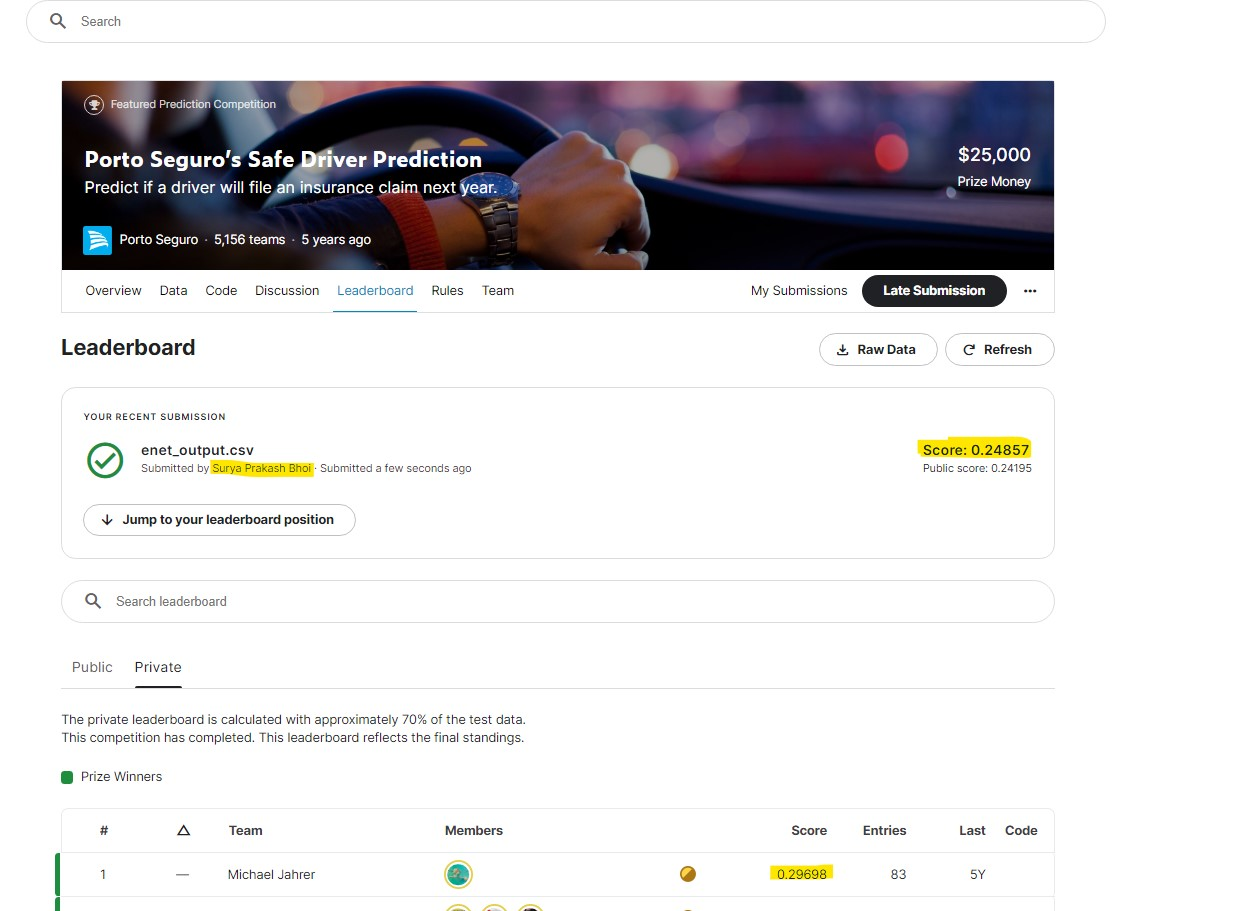